# 第二章

In [2]:
# !pip install pandas_datareader

In [3]:
#导入必要的库
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#指定下载股票的日期范围
start_date = '2020-01-01'
end_date = '2020-03-20'
#使用yahoo数据源
zgpa = dt.DataReader('601318.ss','yahoo',start_date,end_date)

In [5]:
# 检查数据
zgpa.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.790001,85.879997,85.900002,86.120003,77825207,80.861595
2020-01-03,86.879997,85.900002,86.809998,86.199997,59498001,80.936707
2020-01-06,86.870003,85.500000,85.919998,85.599998,63644804,80.373352
2020-01-07,86.459999,85.669998,86.010002,86.150002,45218832,80.889771
2020-01-08,85.000000,85.000000,85.000000,85.000000,62805311,79.809990


In [24]:
#创建交易信号
#建立一个新数据
zgpa_signal = pd.DataFrame(index=zgpa.index)
zgpa_signal['price'] = zgpa['Adj Close']
#增加一个字段显示价格变化
zgpa_signal['diff'] = zgpa_signal['price'].diff()
#数据清理
zgpa_signal = zgpa_signal.fillna(0.0)
#对数据进行分类，股价上涨或保持，则为0
zgpa_signal['signal'] = np.where(zgpa_signal['diff'] >=0, 0, 1)
#根据信号变化进行下单
zgpa_signal['order'] = zgpa_signal['signal'].diff()*100

In [20]:
zgpa_signal.head()

,price,diff,signal,order
Date,,,,
2020-01-02,80.861595,0.000000,0,NaN
2020-01-03,80.936707,0.075111,0,0.0
2020-01-06,80.373352,-0.563354,1,100.0
2020-01-07,80.889771,0.516418,0,-100.0
2020-01-08,79.809990,-1.079781,1,100.0


## 回测

In [25]:
# 给2万的初始资金
initial_cash = 20000
#增加一个字段，代表交易股票的市值
zgpa_signal['stock'] = zgpa_signal['order']*zgpa_signal['price']
#两次买卖订单变化只差就是仓仓位的变化，
#持仓股票数量变化乘以现价，就是交易产生的现金流
#用初始资金减去现金变化的累加，就是剩余的现金
zgpa_signal['cash'] = initial_cash - (zgpa_signal['order'].diff()*zgpa_signal['price']).cumsum()
#股票市值+剩余现金 = 总资产
zgpa_signal['total'] = zgpa_signal['stock'] + zgpa_signal['cash']

展示资产变化

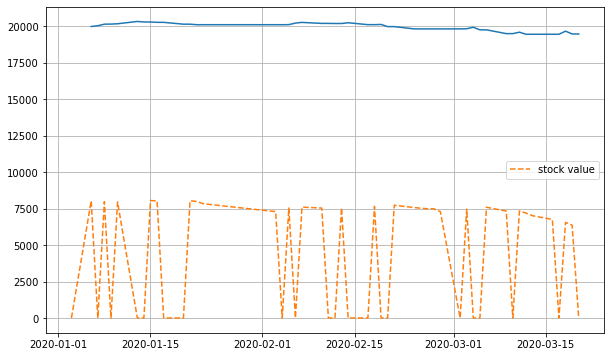

In [32]:
plt.figure(figsize=(10,6))
#分别绘制总资产和持仓市值变化
plt.plot(zgpa_signal['total'])
plt.plot(zgpa_signal['order'].cumsum()*zgpa_signal['price'],'--',label='stock value')
#增加网格，调整一下图注的位置
plt.grid()
plt.legend(loc='center right')
plt.show()

## 2.2 经典策略之移动平均策略

### 2.2.1 单一移动平均

In [38]:
# 使用10日均线
period = 10
# 设置一个空列表，用来存储每10天的价格
avg_10 = []
# 再设置一个空列表，用来存储每10天的均价
avg_value = []
# 设置一个循环
for price in zgpa['Adj Close']:
    avg_10.append(price)
    #保持10个价格
    if len(avg_10) > period:
        del avg_10[0]
    # 将10天数据的均值传入avg_value列表
    avg_value.append(np.mean(avg_10))
# 把计算好的10日均价写到股票价格数据表中
zgpa = zgpa.assign(avg_10 = pd.Series(avg_value,index = zgpa.index))

In [39]:
zgpa.head()

,High,Low,Open,Close,Volume,Adj Close,avg_10
Date,,,,,,,
2020-01-02,86.790001,85.879997,85.900002,86.120003,77825207,80.861595,80.861595
2020-01-03,86.879997,85.900002,86.809998,86.199997,59498001,80.936707,80.899151
2020-01-06,86.870003,85.500000,85.919998,85.599998,63644804,80.373352,80.723885
2020-01-07,86.459999,85.669998,86.010002,86.150002,45218832,80.889771,80.765356
2020-01-08,85.000000,85.000000,85.000000,85.000000,62805311,79.809990,80.574283


**展示**

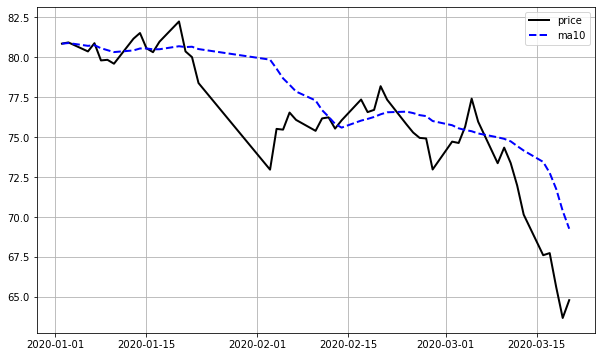

In [47]:
# 设置图形尺寸为 10*6
plt.figure(figsize = (10,6))
# 绘制股价变化
plt.plot(zgpa['Adj Close'], lw=2, c='k', label = 'price')
# 绘制10日均线
plt.plot(zgpa['avg_10'],'--',lw=2,c='b', label = 'ma10')
plt.legend()
plt.grid()
plt.show()

### 2.2.2 双移动平均策略

In [ ]:
# 建立一个新数据表，命名为strategy
strategy = pd.DataFrame(index=zgpa.index)
# 添加一个signal字段，用来存储交易信号
